NDWI CALCULATION OF THE ENTIRE AREA

In [ ]:
!pip3 install gdal
!pip3 install pandas
!pip install rasterio
import numpy as np
import sys

In [ ]:
from osgeo import gdal
import matplotlib.pyplot as plt

import rasterio
from rasterio import plot
infn = './LC08_L1TP_147043_20230108_20230108_02_RT_B3.TIF'
infn2= './LC08_L1TP_147043_20230108_20230108_02_RT_B5.TIF'
outfn = './image.TIF'

def openRaster(fn, access=0):
    ds = gdal.Open(fn, access)
    if ds is None:
        print("Error opening Raster dataset")
    return ds

def getRasterBand(fn, band=1, access=0):
    ds = openRaster(fn, access)
    band1 = ds.GetRasterBand(band).ReadAsArray()
    return band1
# (Band 2 – Band 4)/(Band 2 + Band 4)    
greenband = getRasterBand(infn)
nirband = getRasterBand(infn2)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,6))
plot.show(greenband, ax=ax1, cmap='Blues')
plot.show(nirband, ax=ax2, cmap='Blues')
fig.tight_layout()

In [ ]:

import numpy as np
def createRasterFromTemplate(fn, ds, data, ndv=-9999.0, driverFmt="GTiff"):
    driver = gdal.GetDriverByName(driverFmt)
    outds = driver.Create(fn, xsize=ds.RasterXSize, ysize=ds.RasterYSize, bands=1, eType=gdal.GDT_Float32)
    outds.SetGeoTransform(ds.GetGeoTransform())
    outds.SetProjection(ds.GetProjection())
    outds.GetRasterBand(1).SetNoDataValue(ndv)
    outds.GetRasterBand(1).WriteArray(data)
    outds = None
    ds = None
    
def ndwi(greenband,nirband, ndv=-9999.0):
  ndwiband = (greenband.astype(float)-nirband.astype(float))/(greenband+nirband)
  print(ndwiband[3000,900])
  ndwiband[np.isnan(ndwiband)] = ndv
  return ndwiband
    
ndwiband = ndwi(greenband, nirband)
createRasterFromTemplate(outfn, gdal.Open(infn), ndwiband)

CROPPING THE AOI

In [ ]:
!pip3 install fiona
!pip3 install rasterio
!pip3 install geojson
import fiona
import rasterio
import rasterio.mask
import geojson
#Reading the json file
with open('./aoi.geojson') as f:
    gj = geojson.load(f)
    l=[]
    for i in range(len(gj['features'])):
      l.append(gj['features'][i]['geometry'])
#Checking the CRS of the json file coordinates
with open('./aoi.geojson') as f:
    gj = geojson.load(f)
    print(gj.crs)
#Checking the CRS of the image coordinates
with rasterio.open('./LC08_L1TP_147043_20230108_20230108_02_RT_B3.TIF') as src:
  print(src.crs)
#Conversion of the image EPSG to the json EPSG for the coordinate values to overlap
import numpy as np
import rasterio
from rasterio.warp import calculate_default_transform, reproject, Resampling

dst_crs = 'EPSG:4326'
#Performed for both the bands
with rasterio.open('LC08_L1TP_147043_20230108_20230108_02_RT_B5.TIF') as src:
    transform, width, height = calculate_default_transform(
        src.crs, dst_crs, src.width, src.height, *src.bounds)
    kwargs = src.meta.copy()
    kwargs.update({
        'crs': dst_crs,
        'transform': transform,
        'width': width,
        'height': height
    })

    with rasterio.open('./final.tif', 'w', **kwargs) as dst:
        for i in range(1, src.count + 1):
            reproject(
                source=rasterio.band(src, i),
                destination=rasterio.band(dst, i),
                src_transform=src.transform,
                src_crs=src.crs,
                dst_transform=transform,
                dst_crs=dst_crs,
                resampling=Resampling.nearest)
#Masking/Cropping the raster
import rasterio.mask
infn= './LC08_L1TP_147043_20230108_20230108_02_RT_B3.TIF'
with rasterio.open('./final.tif') as src:
  out_img, out_trans = rasterio.mask.mask(src, l, crop=True)
  out_meta=src.meta

out_meta.update({
    'driver':'Gtiff',
    'height':out_img.shape[1],
    'width':out_img.shape[2],
    'transform':out_trans

})

with rasterio.open('./cropped-img-band5.tif', 'w', **out_meta) as dst:
  dst.write(out_img )

In [ ]:
#Reading the json file
with open('./aoi.geojson') as f:
    gj = geojson.load(f)
    l=[]
    for i in range(len(gj['features'])):
      l.append(gj['features'][i]['geometry'])

In [ ]:
#Checking the CRS of the json file coordinates
with open('./aoi.geojson') as f:
    gj = geojson.load(f)
    print(gj.crs)

In [ ]:
#Checking the CRS of the image coordinates
with rasterio.open('./LC08_L1TP_147043_20230108_20230108_02_RT_B3.TIF') as src:
  print(src.crs)

In [ ]:
#Conversion of the image EPSG to the json EPSG for the coordinate values to overlap
import numpy as np
import rasterio
from rasterio.warp import calculate_default_transform, reproject, Resampling

dst_crs = 'EPSG:4326'
#Performed for both the bands
with rasterio.open('LC08_L1TP_147043_20230108_20230108_02_RT_B5.TIF') as src:
    transform, width, height = calculate_default_transform(
        src.crs, dst_crs, src.width, src.height, *src.bounds)
    kwargs = src.meta.copy()
    kwargs.update({
        'crs': dst_crs,
        'transform': transform,
        'width': width,
        'height': height
    })

    with rasterio.open('./final.tif', 'w', **kwargs) as dst:
        for i in range(1, src.count + 1):
            reproject(
                source=rasterio.band(src, i),
                destination=rasterio.band(dst, i),
                src_transform=src.transform,
                src_crs=src.crs,
                dst_transform=transform,
                dst_crs=dst_crs,
                resampling=Resampling.nearest)

In [ ]:
#Masking/Cropping the raster
import rasterio.mask
infn= './LC08_L1TP_147043_20230108_20230108_02_RT_B3.TIF'
with rasterio.open('./final.tif') as src:
  out_img, out_trans = rasterio.mask.mask(src, l, crop=True)
  out_meta=src.meta

out_meta.update({
    'driver':'Gtiff',
    'height':out_img.shape[1],
    'width':out_img.shape[2],
    'transform':out_trans

})

with rasterio.open('./cropped-img-band5.tif', 'w', **out_meta) as dst:
  dst.write(out_img )

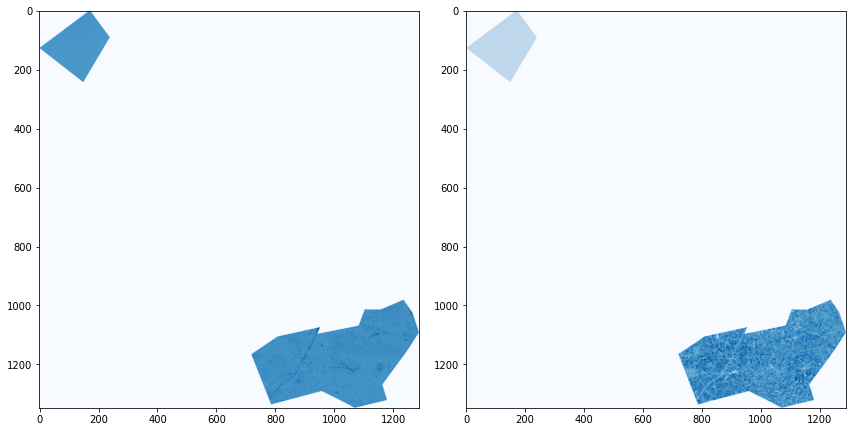

In [ ]:
#Visualizing the cropped rasters.
from osgeo import gdal
import matplotlib.pyplot as plt

import rasterio
from rasterio import plot
infn = '/content/cropped-img.tif'
infn2= '/content/cropped-img-band5.tif'
outfn = './final-cropped-NDWI.tif'

def openRaster(fn, access=0):
    ds = gdal.Open(fn, access)
    if ds is None:
        print("Error opening Raster dataset")
    return ds

def getRasterBand(fn, band=1, access=0):
    ds = openRaster(fn, access)
    band1 = ds.GetRasterBand(band).ReadAsArray()
    return band1
# (Band 3 – Band 5)/(Band 3 + Band 5)    
greenband = getRasterBand(infn)
nirband = getRasterBand(infn2)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,6))
plot.show(greenband, ax=ax1, cmap='Blues')
plot.show(nirband, ax=ax2, cmap='Blues')
fig.tight_layout()

In [ ]:
#Calculating the NDWI of the cropped AOI.
import numpy as np
def createRasterFromTemplate(fn, ds, data, ndv=-9999.0, driverFmt="GTiff"):
    driver = gdal.GetDriverByName(driverFmt)
    outds = driver.Create(fn, xsize=ds.RasterXSize, ysize=ds.RasterYSize, bands=1, eType=gdal.GDT_Float32)
    outds.SetGeoTransform(ds.GetGeoTransform())
    outds.SetProjection(ds.GetProjection())
    outds.GetRasterBand(1).SetNoDataValue(ndv)
    outds.GetRasterBand(1).WriteArray(data)
    outds = None
    ds = None
    
def ndwi(greenband,nirband, ndv=-9999.0):
  ndwiband = (greenband.astype(float)-nirband.astype(float))/(greenband+nirband)
  ndwiband[np.isnan(ndwiband)] = ndv
  return ndwiband
    
ndwiband = ndwi(greenband, nirband)
createRasterFromTemplate(outfn, gdal.Open(infn), ndwiband)